# Photon Orbits with Runge-Kutta 4th Order

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

M = 1
rs = 2*M
r  = 10*rs
dt = 0.01

csi = 0.2490496 #-> one loop and back to observer, #-> np.arcsin(np.sqrt(27/4*(2*M/20)**2*(1-2*M/20))) in orbit about BH 
x_0 = np.array([20, np.pi/2, 0])
ur0, uth0, uph0 = -(1-2*M/20)**(-1/2)*np.cos(csi), 0, 20*np.sin(csi)
u_0 = np.array([ur0, uth0, uph0])


N = int(50.35*rs/dt) # how many loops

### Define RK4 functions

In [88]:
def RHS(x_n, u_n):
    gamma_inv = np.array([
        [(1-rs/(x_n[0])),         0,                           0],
        [0                     , (x_n[0])**-2,                           0],
        [0                     ,         0, (x_n[0])**-2*(np.sin(x_n[1]))**-2] 
    ])
    u0 = np.sqrt(np.tensordot(gamma_inv, np.tensordot(u_n, u_n, axes=0)))/(1-2*M/(x_n[0]))**0.5

    ddt_r = (1-rs/x_n[0])*u_n[0]/u0
    ddt_th = x_n[0]**-2*u_n[1]/u0
    ddt_ph = x_n[0]**-2*np.sin(x_n[1])**-2*u_n[2]/(u0)

    ddt_ur = (-1*M/x_n[0]**2*u0
              +1/u0*(
                  -1*M/x_n[0]**2*u_n[0]**2 
                  + x_n[0]**-3*u_n[1]**2 
                  + x_n[0]**-3*np.sin(x_n[1])**-2*u_n[2]**2
              )
              )
    ddt_uth = u_n[2]**2/(u0) * x_n[0]**-2 * np.sin(x_n[1])**-2*np.tan(x_n[1])**-1
    ddt_uph = 0

    return np.array([ddt_r, ddt_th, ddt_ph, ddt_ur, ddt_uth, ddt_uph])

def RK4_Step(x_n, u_n, dt):
    k1 = RHS(x_n, u_n)
    k2 = RHS(x_n + k1[:3] * dt/2, u_n + k1[3:] * dt / 2)
    k3 = RHS(x_n + k2[:3] * dt/2, u_n + k2[3:] * dt / 2)
    k4 = RHS(x_n + k3[:3] * dt, u_n + k3[3:] * dt)

    x_new = x_n + (k1[:3] + 2*k2[:3] + 2*k3[:3] + k4[:3]) * dt / 6
    u_new = u_n + (k1[3:] + 2*k2[3:] + 2*k3[3:] + k4[3:]) * dt / 6

    return x_new, u_new

### Run Simulation

In [89]:
Xr = np.zeros((N, 3)) 
Ur = np.zeros((N, 3)) 

Xr[0] = x_0
Ur[0] = u_0
for i in tqdm(range(0, N-1)):
    Xr[i+1], Ur[i+1] = RK4_Step(Xr[i], Ur[i], dt) 

100%|██████████| 10069/10069 [00:00<00:00, 13952.67it/s]


In [90]:
#convert to x, y, z from r, theta, phi
x_pos = Xr[:,0]*np.sin(Xr[:,1])*np.cos(Xr[:,2])
y_pos = Xr[:,0]*np.sin(Xr[:,1])*np.sin(Xr[:,2])
z_pos = Xr[:,0]*np.cos(Xr[:,1])

#just for plotting black hole as sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = 2 * np.cos(u) * np.sin(v)
y_sphere = 2 * np.sin(u) * np.sin(v)
z_sphere = 2 * np.cos(v)

dl = np.sqrt(Xr[-1, 0]**2+Xr[0, 0]**2-2*Xr[-1, 0]*Xr[0, 0]*np.cos(Xr[0, 2]-Xr[-1, 2])) #distance metric

### Visualize

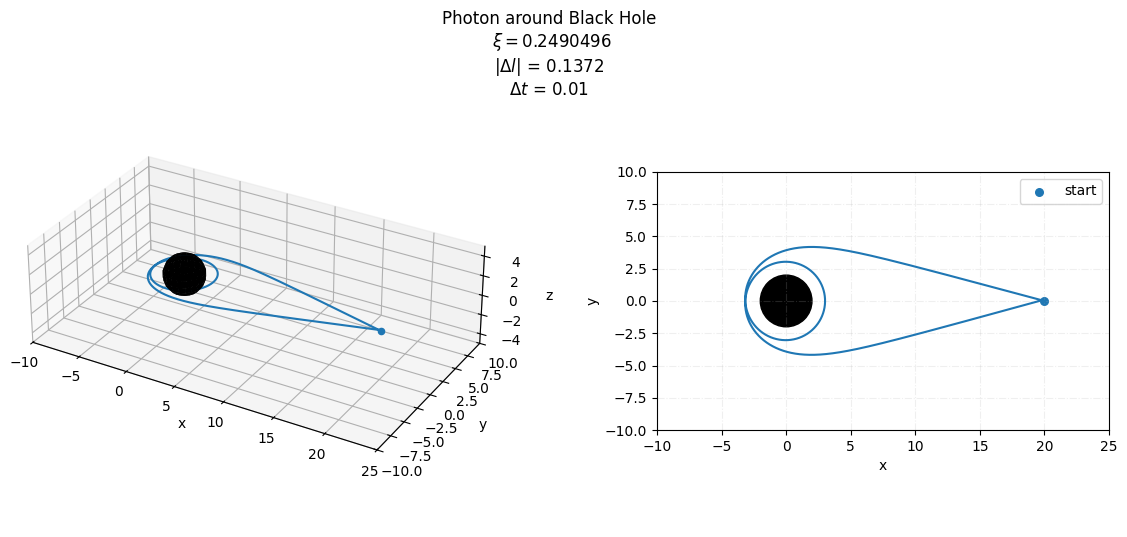

In [91]:
fig = plt.figure(figsize=(14, 6))

plt.suptitle('Photon around Black Hole' + "\n" +fr' $\xi = {csi}$' +"\n" +fr'$|\Delta l|$ = {np.round(dl, 4)}' +"\n" +fr'$\Delta t$ = {np.round(dt, 5)}')
# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_pos, y_pos, z_pos)
ax1.scatter(x_pos[0], y_pos[0], z_pos[0], s=20, label='start')
ax1.plot_surface(x_sphere, y_sphere, z_sphere, color='black', alpha=1)
#ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_xlim(-10, 25)
ax1.set_ylim(-10, 10)
ax1.set_zlim(-5, 5)
ax1.set_aspect('equal')

# 2D plot
ax2 = fig.add_subplot(122)
ax2.plot(x_pos, y_pos)
ax2.scatter(x_pos[0], y_pos[0], s=30, label='start')
ax2.legend()
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
circle = plt.Circle((0, 0), 2, color='black', fill=True)
ax2.add_patch(circle)
ax2.set_xlim(-10, 25)
ax2.set_ylim(-10, 10)
ax2.grid(alpha=0.2, ls='-.')

plt.subplots_adjust(wspace=0.4)

plt.show()

### Big Timestep

In [72]:
Xr = np.zeros((N, 3)) 
Ur = np.zeros((N, 3)) 

Xr[0] = x_0
Ur[0] = u_0
for i in tqdm(range(0, N-1)):
    Xr[i+1], Ur[i+1] = RK4_Step(Xr[i], Ur[i], 2) 

100%|██████████| 10069/10069 [00:00<00:00, 13810.12it/s]


In [73]:
#convert to x, y, z from r, theta, phi
x_pos = Xr[:,0]*np.sin(Xr[:,1])*np.cos(Xr[:,2])
y_pos = Xr[:,0]*np.sin(Xr[:,1])*np.sin(Xr[:,2])
z_pos = Xr[:,0]*np.cos(Xr[:,1])

#just for plotting black hole as sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_sphere = 2 * np.cos(u) * np.sin(v)
y_sphere = 2 * np.sin(u) * np.sin(v)
z_sphere = 2 * np.cos(v)

dl = np.sqrt(Xr[-1, 0]**2+Xr[0, 0]**2-2*Xr[-1, 0]*Xr[0, 0]*np.cos(Xr[0, 2]-Xr[-1, 2])) #distance metric

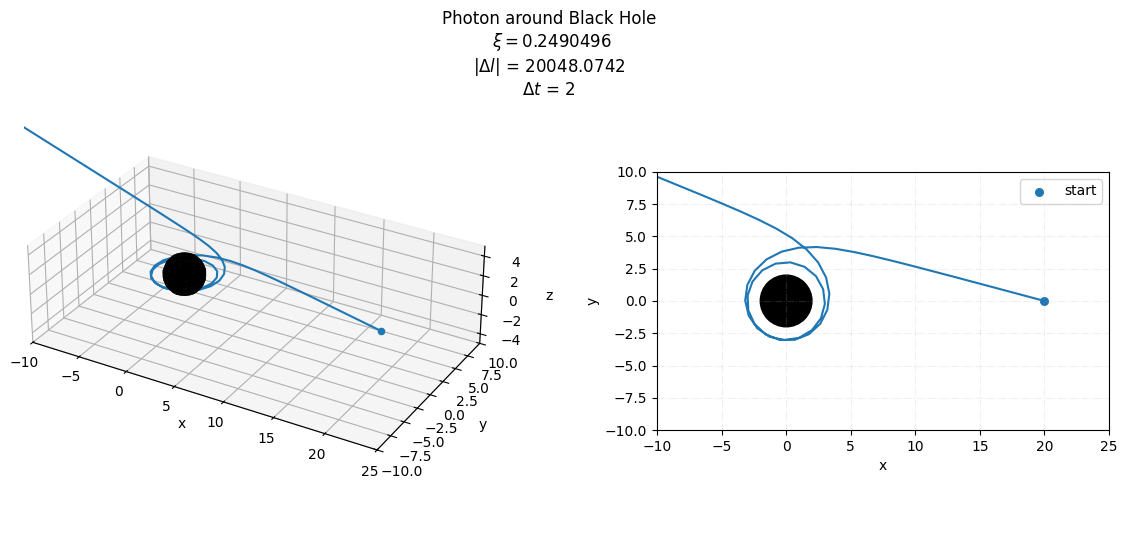

In [75]:
fig = plt.figure(figsize=(14, 6))

plt.suptitle('Photon around Black Hole' + "\n" +fr' $\xi = {csi}$' +"\n" +fr'$|\Delta l|$ = {np.round(dl, 4)}' +"\n" +fr'$\Delta t$ = {2}')
# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_pos, y_pos, z_pos)
ax1.scatter(x_pos[0], y_pos[0], z_pos[0], s=20, label='start')
ax1.plot_surface(x_sphere, y_sphere, z_sphere, color='black', alpha=1)
#ax1.legend()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_xlim(-10, 25)
ax1.set_ylim(-10, 10)
ax1.set_zlim(-5, 5)
ax1.set_aspect('equal')

# 2D plot
ax2 = fig.add_subplot(122)
ax2.plot(x_pos, y_pos)
ax2.scatter(x_pos[0], y_pos[0], s=30, label='start')
ax2.legend()
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
circle = plt.Circle((0, 0), 2, color='black', fill=True)
ax2.add_patch(circle)
ax2.set_xlim(-10, 25)
ax2.set_ylim(-10, 10)
ax2.grid(alpha=0.2, ls='-.')

plt.subplots_adjust(wspace=0.4)

plt.show()

### Many Photons

In [65]:
csi_array = np.linspace(0.21, 0.41, 10)
csi_array[2] = 0.2490496

In [66]:
# Generate random initial conditions around the selected initial conditions
num_photons = 10
random_initial_conditions = []

dt_bigger = 0.1

for _ in range(num_photons):
    csi_rand = csi_array[_]
    random_x0 = np.array([20, np.pi/2, 0])
    random_u0 = ur0, uth0, uph0 = -(1-2*M/20)**(-1/2)*np.cos(csi_rand), 0, 20*np.sin(csi_rand)
    random_initial_conditions.append((random_x0, random_u0))

def simulate_trajectory(initial_conditions):
    x0, u0 = initial_conditions
    Xr_temp = np.zeros((N, 3))
    Ur_temp = np.zeros((N, 3))
    Xr_temp[0] = x0
    Ur_temp[0] = u0
    for i in range(0, N - 1):
        Xr_temp[i + 1], Ur_temp[i + 1] = RK4_Step(Xr_temp[i], Ur_temp[i], dt_bigger)
    return Xr_temp

# Run the simulation for each set of initial conditions sequentially
trajectories = []
for ic in tqdm(random_initial_conditions):
    trajectories.append(simulate_trajectory(ic))


# Generate a second set of random initial conditions with a new starting X position
new_starting_x = 15  # New starting X position
random_initial_conditions_2 = []

for _ in range(num_photons):
    csi_rand = csi_array[_]
    random_x0_2 = np.array([15, np.pi/2, np.pi/2])
    random_u0_2 = ur0, uth0, uph0 = -(1-2*M/new_starting_x)**(-1/2)*np.cos(csi_rand), 0, new_starting_x*np.sin(csi_rand)
    random_initial_conditions_2.append((random_x0_2, random_u0_2))

# Run the simulation for each set of initial conditions sequentially
trajectories_2 = []
for ic in tqdm(random_initial_conditions_2):
    trajectories_2.append(simulate_trajectory(ic))



  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_52570/2924343130.py:15: RuntimeWarning:

overflow encountered in scalar power

/var/folders/cp/8z3h6wl95fn4l6kxwr2y_0hm0000gn/T/ipykernel_52570/2924343130.py:14: RuntimeWarning:

invalid value encountered in scalar multiply

100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


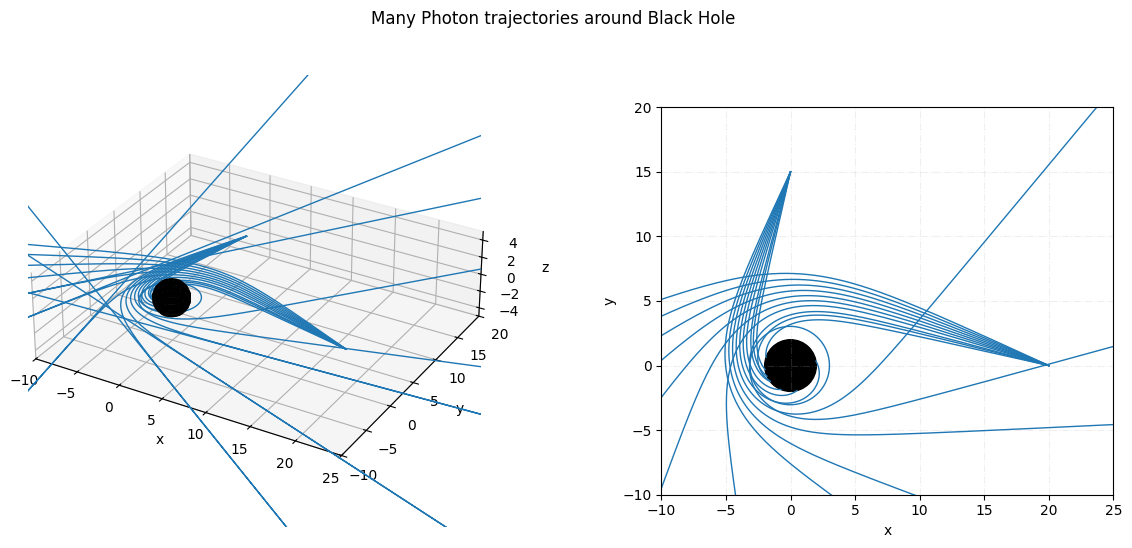

In [70]:
# Plot the trajectories
fig = plt.figure(figsize=(14, 6))
plt.suptitle('Many Photon trajectories around Black Hole')

# 3D plot
ax1 = fig.add_subplot(121, projection='3d')
for Xr_temp in trajectories_2:
    x_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.cos(Xr_temp[:, 2])
    y_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.sin(Xr_temp[:, 2])
    z_pos_temp = Xr_temp[:, 0] * np.cos(Xr_temp[:, 1])
    ax1.plot(x_pos_temp, y_pos_temp, z_pos_temp, c='tab:blue', lw=1)
for Xr_temp in trajectories:
    x_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.cos(Xr_temp[:, 2])
    y_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.sin(Xr_temp[:, 2])
    z_pos_temp = Xr_temp[:, 0] * np.cos(Xr_temp[:, 1])
    ax1.plot(x_pos_temp, y_pos_temp, z_pos_temp, c='tab:blue', lw=1)
ax1.plot_surface(x_sphere, y_sphere, z_sphere, color='black', alpha=1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_xlim(-10, 25)
ax1.set_ylim(-10, 20)
ax1.set_zlim(-5, 5)
ax1.set_aspect('equal')

# 2D plot
ax2 = fig.add_subplot(122)
for Xr_temp in trajectories_2:
    x_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.cos(Xr_temp[:, 2])
    y_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.sin(Xr_temp[:, 2])
    ax2.plot(x_pos_temp, y_pos_temp, c='tab:blue', lw=1)
for Xr_temp in trajectories:
    x_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.cos(Xr_temp[:, 2])
    y_pos_temp = Xr_temp[:, 0] * np.sin(Xr_temp[:, 1]) * np.sin(Xr_temp[:, 2])
    ax2.plot(x_pos_temp, y_pos_temp, c='tab:blue', lw=1)
circle = plt.Circle((0, 0), 2, color='black', fill=True)
ax2.add_patch(circle)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim(-10, 25)
ax2.set_ylim(-10, 20)
ax2.set_aspect('equal')
ax2.grid(alpha=0.2, ls='-.')

plt.subplots_adjust(wspace=0.4)
plt.show()

### Testing Accuracy with Step Size

In [57]:
# Define a range of delta t values
delta_t_values =np.asarray([0.0001, 0.001, 0.01, 0.1, 1])

# Initialize an array to store the delta l values
delta_l_values = []

# Calculate delta l for each delta t
for delta_t in tqdm(delta_t_values):
    end_temp = int(50.4 * rs / delta_t)
    Xr_temp = np.zeros((end_temp, 3))
    Ur_temp = np.zeros((end_temp, 3))
    Xr_temp[0] = x_0
    Ur_temp[0] = u_0
    for i in range(0, end_temp - 1):
        Xr_temp[i + 1], Ur_temp[i + 1] = RK4_Step(Xr_temp[i], Ur_temp[i], delta_t)
    dl_temp = np.sqrt(Xr_temp[-1, 0]**2 + Xr_temp[0, 0]**2 - 2 * Xr_temp[-1, 0] * Xr_temp[0, 0] * np.cos(Xr_temp[0, 2] - Xr_temp[-1, 2]))
    delta_l_values.append(dl_temp)



100%|██████████| 5/5 [01:06<00:00, 13.32s/it]


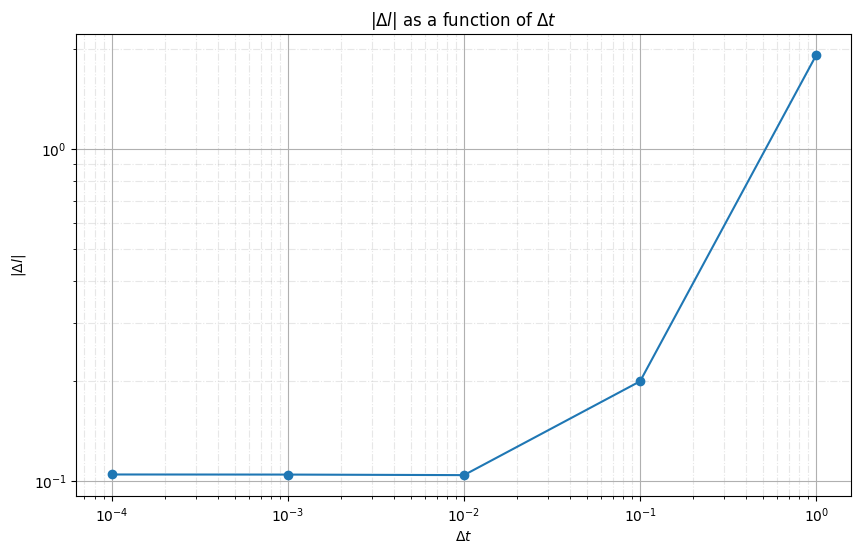

In [71]:
# Plot delta l as a function of delta t
plt.figure(figsize=(10, 6))
plt.plot(delta_t_values, delta_l_values, marker='o')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$|\Delta l|$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'$|\Delta l|$ as a function of $\Delta t$')
plt.grid(True)
#show minor tick grid lines
plt.grid(which='minor', alpha=0.3, ls='-.')
plt.show()